# Lab | Making predictions with logistic regression

**In this lab, you will be using the Sakila database of movie rentals.**

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

**Instructions**

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.
2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.
3. Read the data into a Pandas dataframe.
4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict this variable from the cleaned data.
Evaluate the results.

In [36]:
import pymysql
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import getpass 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [9]:
password = getpass.getpass()

········


In [10]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

With some help from Ferreira I managed to import the cells I want. I adapted his SQL code to import values I deemed importaint: film id, times a movie was rented in total, True/False whether it was rented in May, and how often that month, rental duration, length, rating, category and rental rate.

I did not include information such as extra features (I don't believe they would matter much), Language (they are all English anyways), Title (we are judging by factors like category & rating, length, price and historical demand and have the id if we need to find out titles)

In [11]:
query = '''SELECT f.film_id, COUNT(r.rental_id) AS times_rented, f.rental_duration, f.length,
f.rating, c.name AS category, COUNT(DISTINCT i.inventory_id) AS stock, f.rental_rate, 
	CASE
    WHEN r.rental_date BETWEEN '2005-05-01' AND '2005-05-31' THEN TRUE
    ELSE FALSE END AS may  
FROM sakila.film f
LEFT JOIN sakila.inventory i
    ON f.film_id = i.film_id
LEFT JOIN sakila.rental r
    ON i.inventory_id = r.inventory_id
JOIN sakila.film_category fc
    ON fc.film_id = f.film_id
JOIN sakila.category c
    ON c.category_id = fc.category_id
GROUP BY film_id;'''

In [12]:
film = pd.read_sql(query, engine)
film.head()

,film_id,times_rented,rental_duration,length,rating,category,stock,rental_rate,may
0,1,24,6,86,PG,Documentary,8,0.99,0
1,2,7,3,48,G,Horror,3,4.99,0
2,3,12,7,50,NC-17,Documentary,4,2.99,0
3,4,23,5,117,G,Horror,7,2.99,0
4,5,12,6,130,G,Family,3,2.99,1


### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [13]:
film.shape

(1000, 9)

In [14]:
film.isna().sum()

film_id            0
times_rented       0
rental_duration    0
length             0
rating             0
category           0
stock              0
rental_rate        0
may                0
dtype: int64

In [22]:
film.describe().T


,count,mean,std,min,25%,50%,75%,max
film_id,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
times_rented,1000.0,16.045,7.349080,0.0,11.00,16.0,21.00,34.0
length,1000.0,115.272,40.426332,46.0,80.00,114.0,149.25,185.0
stock,1000.0,4.581,2.020277,0.0,3.00,5.0,6.00,8.0
may,1000.0,0.197,0.397931,0.0,0.00,0.0,0.00,1.0


In [16]:
film.dtypes


film_id              int64
times_rented         int64
rental_duration      int64
length               int64
rating              object
category            object
stock                int64
rental_rate        float64
may                  int64
dtype: object

In [24]:
film['rating'].value_counts()

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [25]:
film['category'].value_counts()

Sports         74
Foreign        73
Family         69
Documentary    68
Animation      66
Action         64
New            63
Drama          62
Sci-Fi         61
Games          61
Children       60
Comedy         58
Classics       57
Travel         57
Horror         56
Music          51
Name: category, dtype: int64

In [26]:
film['rental_duration'].value_counts()

6    212
3    203
4    203
7    191
5    191
Name: rental_duration, dtype: int64

In [18]:
film['rental_rate'].value_counts()

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64

I would treat rental duration and rate as categoricals as there are only a handful of preset values for either column

In [19]:
film['rental_rate'] = film['rental_rate'].astype('object') 

In [20]:
film['rental_duration'] = film['rental_duration'].astype('object') 

In [21]:
film.dtypes

film_id             int64
times_rented        int64
rental_duration    object
length              int64
rating             object
category           object
stock               int64
rental_rate        object
may                 int64
dtype: object

In [23]:
# examining relationship between rate and duration

film.groupby(['rental_rate','rental_duration']).agg({'rental_duration':'count'})

rental_duration
rental_rate rental_duration                 
0.99        3                             78
            4                             72
            5                             56
            6                             76
            7                             59
2.99        3                             63
            4                             61
            5                             59
            6                             70
            7                             70
4.99        3                             62
            4                             70
            5                             76
            6                             66
            7                             62

In [28]:
pd.crosstab(film['rental_rate'],film['rental_duration'])

rental_duration,3,4,5,6,7
rental_rate,,,,,
0.99,78,72,56,76,59
2.99,63,61,59,70,70
4.99,62,70,76,66,62


There doesn't appear to be too much distinction between rental durations and price in consumer's eyes

In [ ]:
sns.countplot(x=data.type)

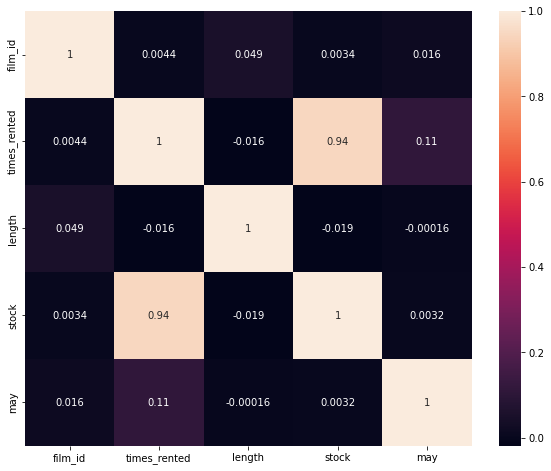

In [31]:
corr_matrix=film.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

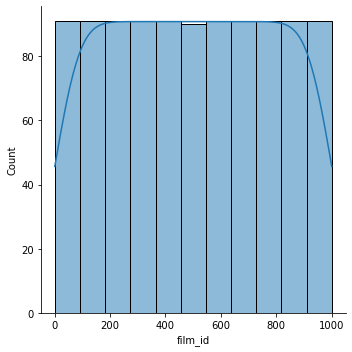

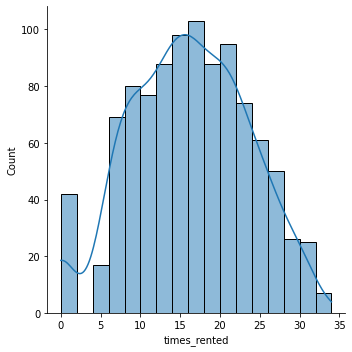

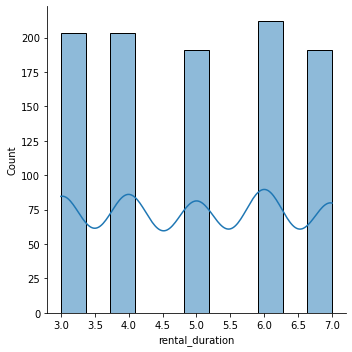

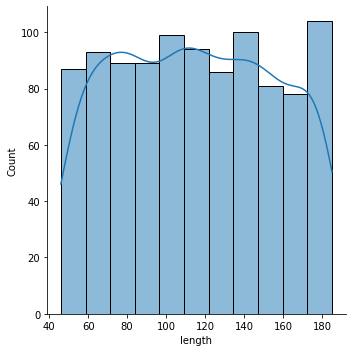

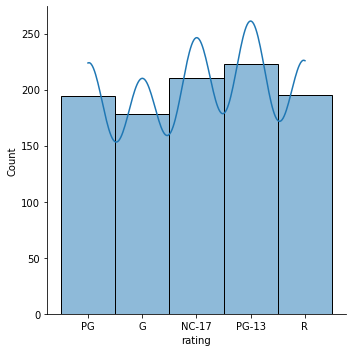

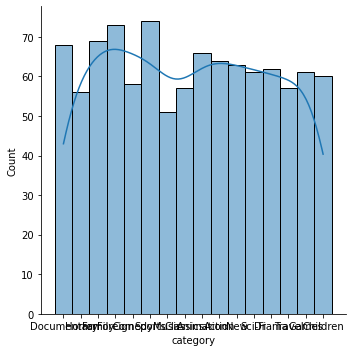

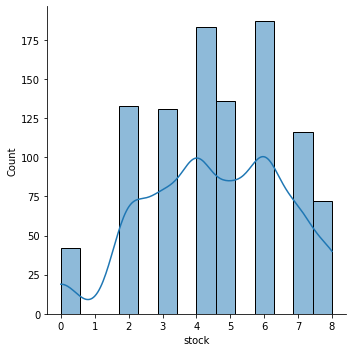

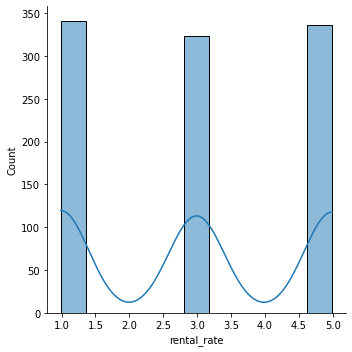

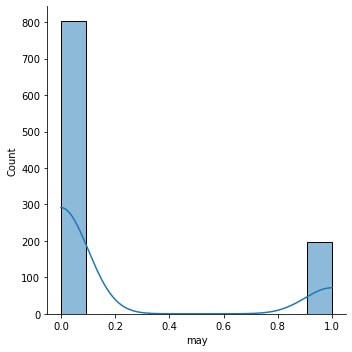

In [32]:
for column in film.columns:
    sns.displot(film[column], kde=True)
    plt.show()

### Xy split
**I selected stock as my y category for it has the single 'best' correlation in our dataset**

In [34]:
y = film['stock']
X = film.drop('stock', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [37]:
X_train_num = X_train.select_dtypes(include = np.number)

transformer = MinMaxScaler().fit(X_train_num) 
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [38]:
X_train_norm.columns = X_train_num.columns
X_train_norm

,film_id,times_rented,length,may
0,0.046092,0.235294,0.769784,0.0
1,0.790581,0.705882,0.151079,0.0
2,0.723447,0.588235,0.258993,1.0
3,0.283567,0.852941,0.223022,0.0
4,0.039078,0.470588,0.733813,0.0
...,...,...,...,...
795,0.167335,0.176471,0.151079,0.0
796,0.232465,0.558824,0.683453,0.0
797,0.861723,0.617647,0.467626,0.0
798,0.189379,0.411765,0.906475,0.0


In [40]:
X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rental_duration', 'rating', 'category', 'rental_rate'],
                             drop_first=True)
X_train_cat.head()

/Users/NicolasVollmerMac/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,...,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99
46,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
789,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
722,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
283,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
39,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


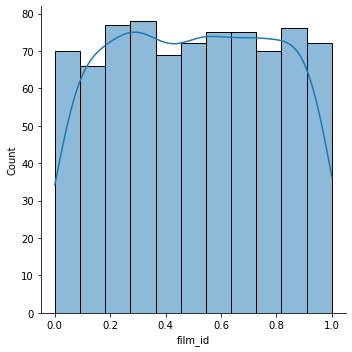

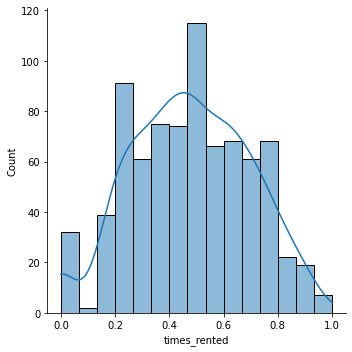

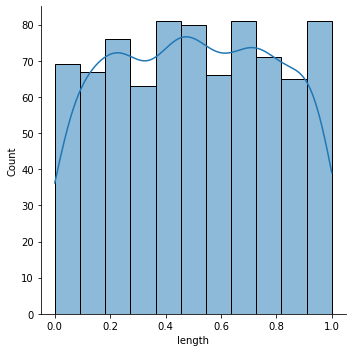

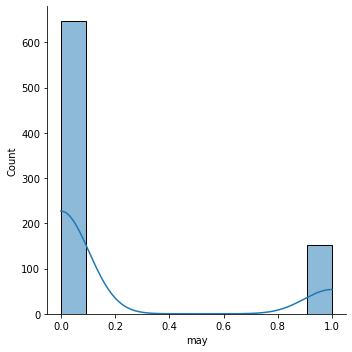

In [41]:
for column in X_train_norm.columns:
    sns.displot(X_train_norm[column], kde=True)
    plt.show()

In [43]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [44]:
X_train_transformed

array([[0.04609218, 0.23529412, 0.76978417, ..., 0.        , 0.        ,
        1.        ],
       [0.79058116, 0.70588235, 0.15107914, ..., 0.        , 0.        ,
        0.        ],
       [0.72344689, 0.58823529, 0.25899281, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.86172345, 0.61764706, 0.4676259 , ..., 0.        , 0.        ,
        1.        ],
       [0.18937876, 0.41176471, 0.90647482, ..., 0.        , 0.        ,
        1.        ],
       [0.15130261, 0.44117647, 0.31654676, ..., 0.        , 1.        ,
        0.        ]])

In [45]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

No system warning on the lbfgs solver, proceeding to the next step

In [46]:
X_test_num = X_test.select_dtypes(include = np.number)

X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [47]:
X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rental_duration', 'rating', 'category', 'rental_rate'],
                            drop_first=True)

X_test_cat.head()

/Users/NicolasVollmerMac/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,...,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99
977,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
56,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
801,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
747,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))

[('rental_duration_4', 'rental_duration_4'),
 ('rental_duration_5', 'rental_duration_5'),
 ('rental_duration_6', 'rental_duration_6'),
 ('rental_duration_7', 'rental_duration_7'),
 ('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('category_Animation', 'category_Animation'),
 ('category_Children', 'category_Children'),
 ('category_Classics', 'category_Classics'),
 ('category_Comedy', 'category_Comedy'),
 ('category_Documentary', 'category_Documentary'),
 ('category_Drama', 'category_Drama'),
 ('category_Family', 'category_Family'),
 ('category_Foreign', 'category_Foreign'),
 ('category_Games', 'category_Games'),
 ('category_Horror', 'category_Horror'),
 ('category_Music', 'category_Music'),
 ('category_New', 'category_New'),
 ('category_Sci-Fi', 'category_Sci-Fi'),
 ('category_Sports', 'category_Sports'),
 ('category_Travel', 'category_Travel'),
 ('rental_rate_2.99', 'rental_rate_2.99'),
 ('rental_rate_4.99', 

In [49]:
X_test_cat.head()

,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,...,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rental_rate_2.99,rental_rate_4.99
977,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
56,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
801,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
747,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [51]:
predictions = classification.predict(X_test_transformed)
predictions

array([4, 2, 6, 0, 7, 4, 6, 6, 4, 5, 7, 4, 6, 6, 4, 4, 6, 5, 3, 3, 4, 6,
       6, 6, 2, 4, 3, 2, 2, 2, 5, 2, 5, 5, 4, 7, 6, 3, 6, 4, 4, 7, 6, 6,
       3, 7, 6, 4, 6, 6, 4, 4, 5, 6, 2, 6, 2, 2, 5, 7, 6, 4, 4, 4, 4, 2,
       6, 6, 2, 6, 7, 3, 4, 6, 4, 6, 7, 6, 2, 3, 6, 4, 4, 2, 6, 4, 6, 2,
       2, 6, 7, 6, 6, 4, 6, 4, 2, 2, 6, 6, 5, 4, 8, 5, 4, 6, 3, 6, 3, 4,
       3, 2, 6, 5, 3, 6, 7, 5, 3, 5, 2, 2, 4, 6, 4, 3, 5, 3, 4, 6, 7, 4,
       4, 2, 6, 5, 4, 6, 3, 7, 2, 4, 4, 8, 4, 4, 4, 2, 3, 3, 6, 4, 2, 3,
       4, 6, 4, 4, 6, 2, 6, 4, 3, 2, 6, 4, 3, 6, 8, 3, 6, 6, 8, 5, 4, 2,
       2, 4, 2, 6, 7, 7, 4, 4, 3, 4, 6, 4, 7, 6, 4, 6, 2, 4, 7, 4, 6, 7,
       6, 4])

In [52]:
print(y_test.value_counts())


6    40
5    32
2    32
4    31
3    25
7    20
0    10
8    10
Name: stock, dtype: int64


In [53]:
pd.Series(predictions).value_counts()


6    56
4    55
2    30
3    22
7    17
5    15
8     4
0     1
dtype: int64

In [54]:
classification.score(X_test_transformed, y_test)

0.33

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 1,  9,  0,  0,  0,  0,  0,  0],
       [ 0, 16, 10,  6,  0,  0,  0,  0],
       [ 0,  4,  5, 14,  2,  0,  0,  0],
       [ 0,  1,  6, 16,  4,  4,  0,  0],
       [ 0,  0,  1, 10,  4, 14,  3,  0],
       [ 0,  0,  0,  9,  5, 19,  7,  0],
       [ 0,  0,  0,  0,  0, 15,  3,  2],
       [ 0,  0,  0,  0,  0,  4,  4,  2]])

In [56]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.18

In [57]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.195

In [58]:
confusion_matrix(y_test, predictions_clf)

array([[ 2,  5,  1,  2,  0,  0,  0,  0],
       [ 2, 11,  7,  7,  1,  3,  1,  0],
       [ 1,  5,  7,  6,  2,  3,  1,  0],
       [ 2,  8,  5,  7,  5,  2,  2,  0],
       [ 3,  4,  6,  7,  7,  3,  2,  0],
       [ 2,  8, 10,  8,  8,  3,  1,  0],
       [ 1,  3,  5,  4,  2,  2,  2,  1],
       [ 0,  2,  2,  3,  0,  2,  1,  0]])

In [59]:
pd.Series(y_test).value_counts()

6    40
5    32
2    32
4    31
3    25
7    20
0    10
8    10
Name: stock, dtype: int64

In [60]:
pd.Series(predictions_clf).value_counts()

2    46
4    44
3    43
5    25
6    18
0    13
7    10
8     1
dtype: int64